# 🎓 AI 질문 자동 생성기 (책 기반)

이 노트북은 책 제목을 입력하면 ChatGPT API를 사용해 **에세이형 토론 질문 22개**를 자동 생성하고, Google Sheets에 저장하는 워크플로우입니다.

📌 이 노트북은 다음을 포함합니다:
- OpenAI API 설정
- 책 제목 입력
- GPT-3.5로 질문 생성
- pandas로 정리
- Google Sheets 자동 업로드

In [ ]:
# ✅ 필요한 라이브러리 설치 (최초 1회 실행)
!pip install --upgrade openai gspread oauth2client pandas --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 656.2 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 734.4/734.4 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 22.2 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.0 which is incompatible.
dask-cudf-cu12 25.2.2 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.
cudf-cu12 25.2.1 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.0 which is incompatible.


## 🔐 OpenAI API 키 입력
- 아래 코드에 본인의 API 키(`sk-...`)를 넣으세요.
- GPT-4 접근권한이 없을 경우 GPT-3.5로 자동 생성됩니다.

In [ ]:
from openai import OpenAI
import pandas as pd

# 여기에 세연의 OpenAI API 키 입력
client = OpenAI(api_key="")

## 📁 Google Sheets 인증파일 업로드
- Google Cloud Console에서 `credentials.json` 다운로드 받아 업로드하세요.
- 서비스 계정 이메일을 Google Sheets 문서에 공유해야 합니다.

In [ ]:
from google.colab import files
uploaded = files.upload()

Saving credentials.json to credentials (2).json


## 📚 분석할 책 목록 정의
- 책 제목과 저자 이름을 리스트 형식으로 입력합니다.
- 여러 권 입력 가능

In [ ]:
# Step 1. 구글 시트 연동 (credentials.json 필요)
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import pandas as pd

scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("credentials.json", scope)
gc = gspread.authorize(creds)

# Step 2. 시트 열기 및 Sheet2 가져오기
sheet = gc.open("AI_Questions_Dataset")
human_sheet = sheet.worksheet("Sheet2")
human_data = pd.DataFrame(human_sheet.get_all_records())



In [ ]:
# 질문이 비어 있지 않은 경우만 필터링
filtered_human_data = human_data[human_data['question'].str.strip() != '']

# 질문이 있는 책들만 추출
unique_books = filtered_human_data[['book_title', 'author']].drop_duplicates()
books = unique_books.rename(columns={"book_title": "title"}).to_dict(orient="records")

# 질문 수 사전 생성
book_counts = filtered_human_data.groupby(["book_title", "author"]).size().reset_index(name="count")
book_to_count = {
    (row["book_title"], row["author"]): row["count"]
    for _, row in book_counts.iterrows()
}

# 결과 확인
for book in books:
    key = (book["title"], book["author"])
    print(f"{book} → 질문 수: {book_to_count.get(key)}")


{'title': 'The Lemonade War', 'author': 'Jacqueline Davies'} → 질문 수: 22
{'title': 'The Lemonade Crime', 'author': 'Jacqueline Davies'} → 질문 수: 21
{'title': 'The Lemonade Crime', 'author': 'Matt Haig'} → 질문 수: 1
{'title': 'A Boy Called Christmas', 'author': 'Matt Haig'} → 질문 수: 21
{'title': 'A Boy Called Christmas', 'author': 'Richard Peck'} → 질문 수: 1
{'title': 'A Year Down Yonder', 'author': 'Richard Peck'} → 질문 수: 21
{'title': 'A Year Down Yonder', 'author': 'Katherine Paterson'} → 질문 수: 1
{'title': 'Bridge to Terabitha', 'author': 'Katherine Paterson'} → 질문 수: 21
{'title': 'Bridge to Terabitha', 'author': 'Louis Sachar'} → 질문 수: 1
{'title': 'Holes', 'author': 'Louis Sachar'} → 질문 수: 21
{'title': 'Holes', 'author': 'Lynne Reid Banks'} → 질문 수: 1
{'title': 'The Indian in the Cupboard', 'author': 'Lynne Reid Banks'} → 질문 수: 21
{'title': 'The Indian in the Cupboard', 'author': 'Kate DiCamillo'} → 질문 수: 1
{'title': 'The Tale of Despereaux', 'author': 'Kate DiCamillo'} → 질문 수: 21
{'title': 

## ✨ GPT-3.5를 사용한 질문 생성 함수
- 에세이형, 비판적 사고 기반 질문 22개 생성
- 1~22번 형식으로 출력된 질문만 추출

In [ ]:
# Step 4. 질문 수 가져오기
book_counts = filtered_human_data.groupby(["book_title", "author"]).size().reset_index(name="count")
book_to_count = {
    (row["book_title"], row["author"]): row["count"]
    for _, row in book_counts.iterrows()
}

In [ ]:
# Step 5. AI 질문 생성 함수
def generate_questions(book, num_questions):
    prompt = f"""
You are an experienced curriculum designer for middle and high school humanities classes.
Please generate {num_questions} unique, high-quality essay-style discussion questions based on the book titled \"{book['title']}\" by {book['author']}. Questions should promote deep thinking, character analysis, and real-world themes. Format:
1. ...
2. ...
...
{num_questions}. ...
"""
    try:
        response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=[{"role": "user", "content": prompt}],
            temperature=0.7
        )
        content = response.choices[0].message.content
        return [line.strip()[3:].strip() for line in content.split('\n') if line.strip().startswith(tuple("123456789"))]
    except Exception as e:
        print(f"⚠️ 오류 발생 for {book['title']}: {e}")
        return []

## 📊 질문 생성 및 DataFrame 저장 & 📤 Google Sheets에 자동 업로드
- pandas DataFrame으로 정리하고 csv로 저장

In [ ]:
# ✅ 질문 생성 및 저장
all_ai_questions = []

for book in books:
    key = (book["title"], book["author"])
    num_q = book_to_count.get(key, 0)

    if num_q == 0:
        print(f"❗ '{book['title']}'에 대한 사람이 만든 질문이 없어 건너뜀")
        continue

    qlist = generate_questions(book, num_q)

    for i, q in enumerate(qlist):
        all_ai_questions.append({
            "book_title": book["title"],
            "author": book["author"],
            "question_number": i + 1,
            "question": q,
            "length": len(q),
            "source": "AI"
        })


## 📤 DataFrame 저장 &  Google Sheets에 자동 업로드
- pandas DataFrame으로 정리하고 csv로 저장

In [ ]:
# 1. AI 질문 리스트 → DataFrame 변환
df_ai = pd.DataFrame(all_ai_questions)


# 2. Sheet1 덮어쓰기 방식으로 Google Sheets에 저장
try:
    sheet.del_worksheet(sheet.worksheet("Sheet1"))
except:
    pass
sheet.add_worksheet(title="Sheet1", rows="1000", cols="10")
ai_sheet = sheet.worksheet("Sheet1")
ai_sheet.update([df_ai.columns.values.tolist()] + df_ai.values.tolist())
print("✅ Google Sheets 업로드 완료")


✅ Google Sheets 업로드 완료


In [ ]:
# 3. CSV 파일로도 병렬 저장 (백업 + 분석용)
df_ai.to_csv("ai_questions.csv", index=False)
df_ai.head()

,book_title,author,question_number,question,length,source
0,The Lemonade War,Jacqueline Davies,1,How does the sibling rivalry between Jessie an...,94,AI
1,The Lemonade War,Jacqueline Davies,2,In what ways does the lemonade stand competiti...,102,AI
2,The Lemonade War,Jacqueline Davies,3,How does the concept of entrepreneurship play ...,139,AI
3,The Lemonade War,Jacqueline Davies,4,Discuss the importance of communication and te...,131,AI
4,The Lemonade War,Jacqueline Davies,5,How do Jessie and Evan's differing personaliti...,147,AI


# 🤖 vs 👤 AI 질문 vs 인간 질문 분석 노트북

이 노트북은 Google Sheets에 있는 Sheet1(AI 질문), Sheet2(인간 질문)을 기반으로 다음 항목을 비교 분석합니다:

- 문장 길이 평균, 단어 수, Type-Token Ratio
- 가독성 점수 (Flesch, Gunning Fog)
- Lexical 다양성 (hapax legomena 비율)
- SBERT 임베딩 → UMAP/t-SNE 시각화

✅ 사전 요구사항:
- Sheet1, Sheet2가 같은 구조로 되어 있어야 함 (book_title, author, question_number, question, length, source)

In [ ]:
!pip install gspread oauth2client textstat sentence-transformers umap-learn matplotlib seaborn --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.3/175.3 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 363.4/363.4 MB 21.5 MB/s eta 0:00:01

In [ ]:
import pandas as pd
import gspread
from oauth2client.service_account import ServiceAccountCredentials
import textstat
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns
from sentence_transformers import SentenceTransformer
import umap
from sklearn.preprocessing import LabelEncoder

In [ ]:
# ✅ Google Sheets 연동
scope = ["https://spreadsheets.google.com/feeds", "https://www.googleapis.com/auth/drive"]
creds = ServiceAccountCredentials.from_json_keyfile_name("credentials.json", scope)
gc = gspread.authorize(creds)

sheet = gc.open("AI_Questions_Dataset")
ai_data = pd.DataFrame(sheet.worksheet("Sheet1").get_all_records())
human_sheet = sheet.worksheet("Sheet2")
human_data = pd.DataFrame(human_sheet.get_all_records())

# 📌 Sheet2에 length 및 source 컬럼 자동 생성 및 업데이트
human_data["length"] = human_data["question"].apply(len)
human_data["source"] = "Human"
human_sheet.clear()
human_sheet.update([human_data.columns.values.tolist()] + human_data.values.tolist())


{'spreadsheetId': '1LHF_0v3woLI7q2MBhryjcGjvPRnPfHCwah7NWeeUMcg',
 'updatedRange': 'Sheet2!A1:F507',
 'updatedRows': 507,
 'updatedColumns': 6,
 'updatedCells': 3042}

## 📊 언어 통계 분석 함수 정의
- 문장 길이, 단어 수, TTR, 가독성, 희귀 단어 등

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
# 분석 수행
ai_stats = ai_data['question'].apply(analyze_text).apply(pd.Series)
human_stats = human_data['question'].apply(analyze_text).apply(pd.Series)

ai_data = pd.concat([ai_data, ai_stats], axis=1)
human_data = pd.concat([human_data, human_stats], axis=1)

ai_data['label'] = 'AI'
human_data['label'] = 'Human'
combined = pd.concat([ai_data, human_data])

## 📉 기본 비교 시각화 (문장 길이, TTR, 가독성 등)

이 분석에서는 AI 질문과 인간 질문 간의 **언어적 차이**를 시각화합니다.

사용된 지표는 다음과 같습니다:
- `word_count`: 문장의 총 단어 수
- `ttr` (Type-Token Ratio): 단어 다양성 비율
- `hapax_ratio`: 한 번만 등장한 희귀 단어 비율
- `flesch`: Flesch 읽기 용이도 (높을수록 쉬운 문장)
- `gunning_fog`: Gunning Fog 지수 (높을수록 난해한 문장)

아래 박스플롯(Boxplot)은 각 지표별로 AI와 Human 질문의 분포를 비교합니다.


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


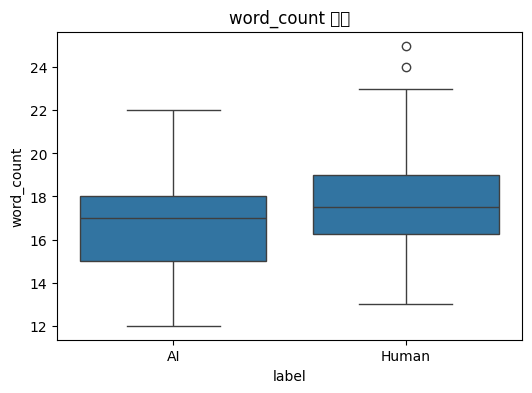

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


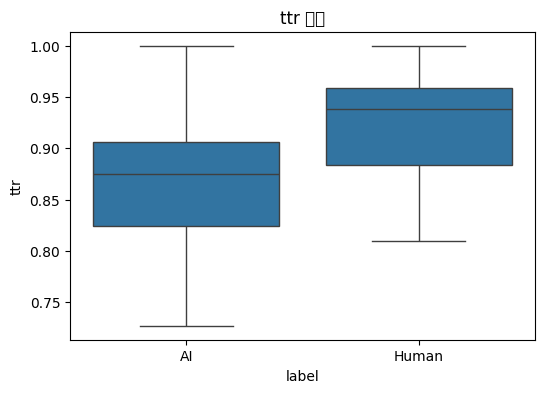

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


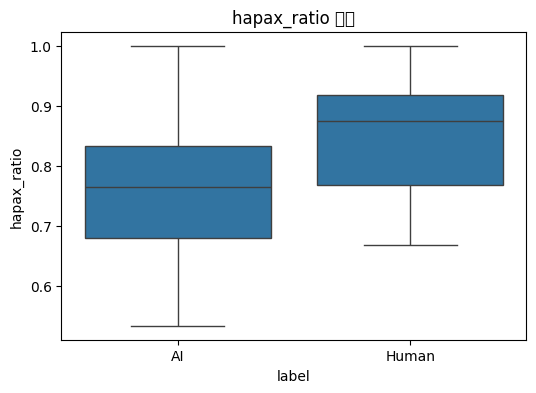

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


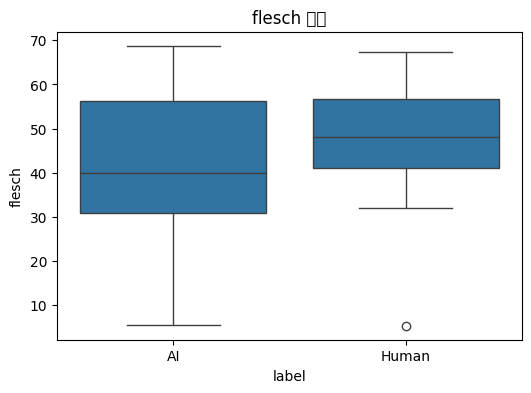

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44368 (\N{HANGUL SYLLABLE GYO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


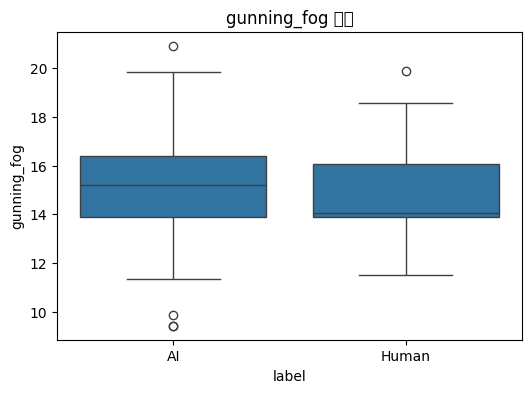

In [ ]:
metrics = ['word_count', 'ttr', 'hapax_ratio', 'flesch', 'gunning_fog']
for metric in metrics:
    plt.figure(figsize=(6,4))
    sns.boxplot(data=combined, x='label', y=metric)
    plt.title(f"{metric} 비교")
    plt.show()

## 📖 Boxplot 해석 방법

| 구성 요소 | 의미 |
|------------|------|
| 상자(Box) | 중간 50% 데이터 분포 (IQR: Q1~Q3) |
| 가로선    | 중앙값 (Median) |
| 수염(Whisker) | Q1 - 1.5×IQR 또는 Q3 + 1.5×IQR 범위 |
| ● 점들     | 이상치 (Outliers) |

### 🔍 지표별 해석
- **`word_count`**: 평균적으로 누가 더 긴 질문을 쓰는가?
- **`ttr`**: 다양한 단어를 더 사용하는 쪽은?
- **`hapax_ratio`**: 희귀 단어 사용이 많은 쪽은?
- **`flesch`**: 어떤 질문이 더 읽기 쉬운가?
- **`gunning_fog`**: 복잡한 문장은 누가 더 많이 쓰는가?

### 📌 예시 해석 가이드
- `flesch`가 **AI < Human**이면 → AI 문장이 더 어려움
- `ttr`이 **Human > AI**이면 → 인간이 더 다양한 단어 사용
- `word_count`가 비슷하더라도, `gunning_fog`가 다르면 문장 구조의 복잡성이 다름

## 🧠 의미 임베딩 + UMAP 시각화 (SBERT 기반)

해석 가이드
- **같은 영역에 몰려 있음** → 의미적으로 유사한 질문들이 많음
- **AI가 한쪽에 군집** → 반복적 패턴 or 특정 질문 구조에 치우쳐 있음
- **Human이 퍼져 있음** → 다양한 맥락과 표현 방식 사용

시각화 결과에서 AI가 좁은 공간에 몰려 있다면, 이는 "의미 다양성 부족"을 의미할 수 있습니다.

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 51076 (\N{HANGUL SYLLABLE IM}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 48288 (\N{HANGUL SYLLABLE BE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46377 (\N{HANGUL SYLLABLE DING}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/

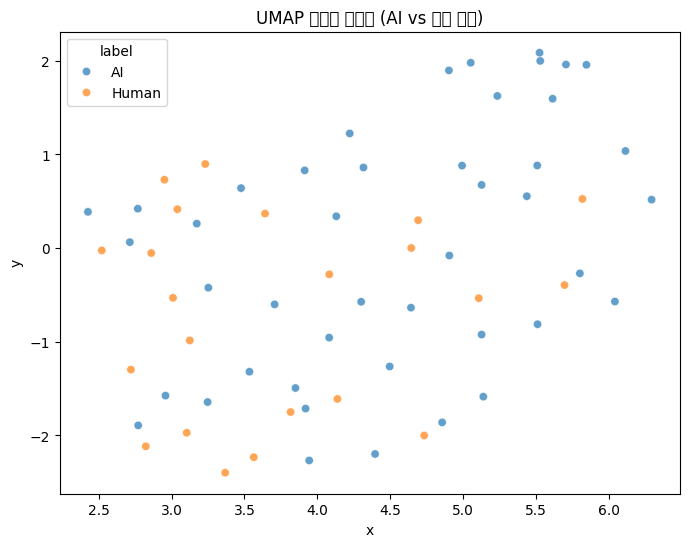

In [ ]:
model = SentenceTransformer('all-MiniLM-L6-v2')
embeddings = model.encode(combined['question'].tolist())

reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, metric='cosine')
embedding_2d = reducer.fit_transform(embeddings)

combined['x'] = embedding_2d[:, 0]
combined['y'] = embedding_2d[:, 1]

plt.figure(figsize=(8,6))
sns.scatterplot(data=combined, x='x', y='y', hue='label', alpha=0.7)
plt.title("UMAP 임베딩 시각화 (AI vs 인간 질문)")
plt.show()

## 📊 통계적 유의성 검정 (t-test, Mann-Whitney U)

두 집단(AI vs Human)의 평균 차이가 통계적으로 **유의미한지** 검정합니다.

- 정규성 가정: t-test (독립표본)
- 비모수: Mann-Whitney U test (순위 기반)

In [ ]:
from scipy.stats import ttest_ind, mannwhitneyu

for metric in ['word_count', 'ttr', 'hapax_ratio', 'flesch', 'gunning_fog']:
    print(f"\n📌 {metric} 비교:")
    group1 = ai_data[metric].dropna()
    group2 = human_data[metric].dropna()

    t_stat, t_p = ttest_ind(group1, group2, equal_var=False)
    u_stat, u_p = mannwhitneyu(group1, group2, alternative='two-sided')

    print(f"t-test p-value: {t_p:.4f} ({'유의함' if t_p < 0.05 else '차이 없음'})")
    print(f"Mann-Whitney U p-value: {u_p:.4f} ({'유의함' if u_p < 0.05 else '차이 없음'})")


📌 word_count 비교:
t-test p-value: 0.1100 (차이 없음)
Mann-Whitney U p-value: 0.1098 (차이 없음)

📌 ttr 비교:
t-test p-value: 0.0018 (유의함)
Mann-Whitney U p-value: 0.0023 (유의함)

📌 hapax_ratio 비교:
t-test p-value: 0.0012 (유의함)
Mann-Whitney U p-value: 0.0024 (유의함)

📌 flesch 비교:
t-test p-value: 0.1248 (차이 없음)
Mann-Whitney U p-value: 0.1114 (차이 없음)

📌 gunning_fog 비교:
t-test p-value: 0.6819 (차이 없음)
Mann-Whitney U p-value: 0.4789 (차이 없음)
